# Stock price forecasting system
Authors: Leonardo Emili, Alessio Luciani

## Project setup

In [ ]:
try:
    # Setup the project directory if running on Colab
    from google.colab import drive
    !pip install -q wandb pytorch-lightning
    drive.mount('/content/gdrive/')
    !cp gdrive/MyDrive/stock-forecasting-proj/data.zip .
    !unzip -qo data.zip
    !rm -f data.zip
except:
    pass

     |████████████████████████████████| 1.8MB 32.9MB/s 
     |████████████████████████████████| 819kB 40.8MB/s 
     |████████████████████████████████| 133kB 25.1MB/s 
     |████████████████████████████████| 174kB 53.6MB/s 
     |████████████████████████████████| 102kB 13.5MB/s 
     |████████████████████████████████| 276kB 52.8MB/s 
     |████████████████████████████████| 10.6MB 53.0MB/s 
     |████████████████████████████████| 829kB 51.9MB/s 
     |████████████████████████████████| 112kB 54.1MB/s 
     |████████████████████████████████| 71kB 6.7MB/s 
     |████████████████████████████████| 1.3MB 50.6MB/s 
     |████████████████████████████████| 296kB 59.7MB/s 
     |████████████████████████████████| 143kB 47.0MB/s 
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which is incompatible.
ERROR: pytorch-lightning 1.3.6 has requirement PyYAML<=5.4.1,>=5.1, but you'll have pyyaml 3.13 which is incompatible.
Mounted at /content/gdrive/


In [ ]:
%matplotlib inline

# Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass, field, asdict
import plotly.express as px
import missingno as msno
from sklearn.preprocessing import scale

# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl

pl.seed_everything(42)

# General
import glob
from tqdm.notebook import tqdm
from typing import *
import datetime

import wandb
from pytorch_lightning.loggers import WandbLogger
wandb.login(key='147339090e59f6a02bed0fa3f938a2b1ecbc567c')

Global seed set to 42
wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Dataset loading
We load the initial datasets into Pandas dataframes: one for fundamentals data and one for prices of every stock.

In [ ]:
# Key stats dataframe
key_stats_df = pd.read_csv("data/key_stats_yahoo.csv")
key_stats_df.drop(key_stats_df.columns[0], axis=1, inplace=True)
key_stats_df.Date = pd.to_datetime(key_stats_df.Date)

# Prices dataframes for every stock
prices_files = glob.glob("data/prices/*.csv")
dfs_names = [f.rsplit('/', 1)[1][:-len('.csv')] for f in prices_files]
prices_dfs = []
for f in tqdm(prices_files, desc='Reading stock price data', total=len(prices_files)):
    df = pd.read_csv(f)
    df.Date = pd.to_datetime(df.Date)
    prices_dfs.append(df)

## Dataset analysis
Visualize our input data, showing only the top 5 rows of each dataframe.

In [ ]:
print("Key stats dataframe format:")
key_stats_df.head()

Key stats dataframe format:


,Date,Ticker,Price,DE Ratio,Trailing P/E,Price/Sales,Price/Book,Profit Margin,Operating Margin,Return on Assets,Return on Equity,Revenue Per Share,Market Cap,Enterprise Value,Forward P/E,PEG Ratio,Enterprise Value/Revenue,Enterprise Value/EBITDA,Revenue,Gross Profit,EBITDA,Net Income Avl to Common,Diluted EPS,Earnings Growth,Revenue Growth,Total Cash,Total Cash Per Share,Total Debt,Current Ratio,Book Value Per Share,Cash Flow,Beta
0,2004-01-30 19:01:00,a,33.8320,0.407,NaN,2.80,6.01,29.56,11.97,24.95,47.81,12.803,1.745000e+10,1.652000e+10,25.83,3.84,2.73,NaN,2.73,2.290000e+09,NaN,1.790000e+09,3.774,NaN,0.8,1.610000e+09,3.370,1.150000e+09,2.040,5.930,144000000.0,2.474
1,2004-04-13 04:07:00,a,28.4626,0.375,NaN,2.43,4.98,25.56,6.20,23.59,46.82,13.160,1.532000e+10,1.477000e+10,20.83,2.89,2.35,NaN,2.35,2.290000e+09,NaN,1.610000e+09,3.391,NaN,0.8,1.680000e+09,3.490,1.150000e+09,2.284,6.394,144000000.0,2.496
2,2004-12-13 21:37:00,a,21.8816,0.323,33.58,1.61,3.24,4.86,5.38,5.26,10.92,14.610,1.161000e+10,1.037000e+10,15.79,1.62,1.44,15.300,1.44,2.290000e+09,15.300,3.490000e+08,0.710,NaN,0.8,2.320000e+09,4.750,1.150000e+09,2.441,7.320,483000000.0,2.547
3,2005-01-22 05:17:00,a,20.2478,0.322,30.70,1.52,3.04,4.86,5.38,5.26,10.92,14.610,1.071000e+10,9.760000e+09,14.34,1.51,1.36,14.400,1.36,3.120000e+09,14.400,3.490000e+08,0.710,NaN,18.6,2.320000e+09,4.710,1.150000e+09,2.446,7.329,663000000.0,2.166
4,2006-01-09 02:35:00,a,31.7118,2.169,52.82,3.31,4.26,6.38,3.58,1.68,3.69,10.403,1.712000e+10,1.487000e+10,NaN,1.81,2.89,35.665,2.89,3.120000e+09,35.665,1.410000e+08,0.660,64.9,22.8,2.250000e+09,4.555,2.169000e+00,2.169,8.095,890000000.0,NaN


In [ ]:
print("Prices dataframe format:")
prices_dfs[0].head()

Prices dataframe format:


,Date,Low,Open,Volume,High,Close,Adjusted Close
0,1990-12-06,1.083333,0.0000,28022400,1.250000,1.166667,0.825420
1,1990-06-13,1.125000,0.0000,10702800,1.312500,1.291667,0.913858
2,1990-06-14,1.250000,0.0000,5994000,1.354167,1.333333,0.943337
3,1990-06-15,1.270833,0.0000,3896400,1.333333,1.291667,0.913858
4,1990-06-18,1.229167,1.3125,2242800,1.312500,1.239583,0.877009


### Utility functions
Here are a some utility functions that are used across the notebook.

In [ ]:
def prices_df_nan_summary(prices_dfs, names):
    ''' Utility function to summarize columns that have missing values. '''
    nan_dfs = []
    for i, (prices_df, name) in enumerate(zip(prices_dfs, names)):
        nan_cols = []
        nan_values = []
        for column in prices_df.columns:
            nan_absolute = prices_df[column].isnull().sum()
            if nan_absolute > 0:
                # Only consider columns that cointain NaN values
                nan_cols.append(column)
                nan_values.append(nan_absolute)
        if len(nan_cols):
            # Either we have all the data for a given day or we don't have any data for it
            assert len(set(nan_values)) == 1
            count = nan_values[0]
            nan_dfs.append((name, round(100*count/len(prices_df.index), 3), count))
    return pd.DataFrame(nan_dfs, columns=['Stock name', 'Missing data (%)', 'Count'])

def remove_trailing_nan(df: pd.DataFrame, ticker: str, col: str = 'Low') -> pd.DataFrame:
    '''
    A trick to detect if the input DataFrame ends with a contiguous collection of NaN rows.
    It is mainly an adaptation from: https://stackoverflow.com/questions/29007830/identifying-consecutive-nans-with-pandas
    '''
    if ticker == 'CTQ':
        # This special case refers to a stock that is not active for a long period but contains two days of activity:
        # up ..... up down ..... down [up down ... down up] down ..... down
        # We consider the period comprised in square brackets as an inactivity period. Otherwise feature imputation
        # would be harder and less reliable, hence dropping a few rows (i.e. only 2) increases the quality of our data.
        df.iloc[1397] = np.nan
        df.iloc[1400] = np.nan
    group_by_nan = df[col].isnull().astype(int).groupby(df[col].notnull().astype(int).cumsum()).cumsum()
    training_nans = group_by_nan.iloc[-1]
    return df[:-training_nans] if training_nans > 0 else df

def merge_prices_fundamentals(
    prices_dfs: List[pd.DataFrame],
    key_stats_df: pd.DataFrame,
    dfs_names: List[str],
    drop_cols: List[str] = ['Date', 'Price']
    ) -> List[pd.DataFrame]:

    # Define the target list of dataframes
    prices_dfs_new = []
    names_new = []
    for ticker, ticker_df in tqdm(key_stats_df.groupby('Ticker'), desc='Merging the datasets ...'):
        # Consider only stocks for which we have fundamental data
        if ticker.upper() not in dfs_names: continue

        # The current financial report
        ticker_iterator = list(ticker_df.iterrows())
        ticker_iter_idx = 0
        names_new.append(ticker.upper())

        # Merge the two dataset according to the value of ticker_date
        ticker_row = ticker_iterator[ticker_iter_idx][1]
        ticker_date = ticker_row.Date
        ticker_row.drop(drop_cols, inplace=True)
        fundamental_cols, financial_values = ticker_row.index, ticker_row.values

        # Consider the relative stock ticker dataframe
        prices_df_idx = dfs_names.index(ticker.upper())
        prices_df = prices_dfs[prices_df_idx]
        # Dropping unused price value columns (we are using adjusted close)
        prices_df = prices_df.drop(['High', 'Low', 'Open', 'Close'], axis=1)
        fundamental_rows = []

        # Discard events that occurred before the first financial report
        begin_idx = prices_df[prices_df.Date >= ticker_date].index[0]
        for i, row in prices_df[begin_idx:].iterrows():
            # Use the last updated financial report if available (otherwise fast-forward the latest)
            if ticker_date < row.Date and ticker_iter_idx + 1 < len(ticker_iterator):
                # Update info about fundamental data
                ticker_iter_idx += 1
                ticker_row = ticker_iterator[ticker_iter_idx][1]
                ticker_date = ticker_row.Date
                ticker_row.drop(drop_cols, inplace=True)
                financial_values = ticker_row.values
            
            fundamental_rows.append(financial_values)

        # Finally merge the two datasets into one that has the same rows and the union of columns
        fundamental_df = pd.DataFrame(fundamental_rows, columns=fundamental_cols)
        valid_prices_df = prices_df[begin_idx:].reset_index(drop=True)
        merged_df = pd.concat((fundamental_df, valid_prices_df), axis=1)

        assert merged_df.shape == (fundamental_df.shape[0], fundamental_df.shape[1] + valid_prices_df.shape[1])
        prices_dfs_new.append(merged_df)
    
    return prices_dfs_new, names_new

def fill_missing_days(
    aggregate_dfs: List[pd.DataFrame],
    ticker_names: List[str],
    remove_weekends: bool = True,
    end_year: int = 2013
    ) -> List[pd.DataFrame]:
    '''
    Returns the aggregated dataframes where gaps have been filled using fast-forward techniques.
    If remove_weekends is specified, only prices for weekdays are retained.
    '''

    def is_weekday(date: datetime) -> bool:
        ''' Returns true if the provided date corresponds to a weekday. '''
        return date.weekday() < 5

    result_dfs = []
    names_new = []
    for df, ticker_name in tqdm(zip(aggregate_dfs, ticker_names), desc='Filling missing days ...'):
        rows = list(df.iterrows())
        _, last_row = rows[0]
        
        # Skip datasets (less than 2%) whose available data starts after the end_year
        if end_year is not None and last_row.Date.year > end_year: continue
        date_idx = last_row.index.tolist().index("Date")
        names_new.append(ticker_name)

        output_rows = [last_row.values.tolist()]
        for _, row in rows[1:]:
            # Skip rows that exceed the end_year
            if end_year is not None and row.Date.year > end_year: break

            # Compute the current time gap in our dataset
            missing_days = (row.Date - last_row.Date).days - 1
            for day_offset in range(1, missing_days+1):
                # Fill the gap adding [day_offset] days with the last observed values
                delta = datetime.timedelta(days=day_offset)
                output_rows.append(last_row.values.tolist())
                output_rows[-1][date_idx] = last_row.Date + delta

            # Add and update the latest observed values
            output_rows.append(row.values.tolist())
            last_row = row
    
        # Skip weekends
        if remove_weekends:
            output_rows = [row for row in output_rows if is_weekday(row[date_idx])]
        result_dfs.append(pd.DataFrame(output_rows, columns=aggregate_dfs[0].columns))
    return result_dfs, names_new

def train_val_test_split(ds, train_size=0.75, val_size=0.15, test_size=0.10, seed=42):
    ''' Create random splits of the original [DataFrame], nmanually specify the seed for reproducible results. '''
    if train_size + val_size + test_size != 1:
        print('Input proportions do not sum up to 1! Using default values.', file=sys.stderr)
    n, m  = int(len(ds)*train_size), int(len(ds)*val_size)
    lengths = [n, m, len(ds)-n-m]
    return random_split(ds, lengths, generator=torch.Generator().manual_seed(seed))

def r2_score(y_hat: np.ndarray, y: np.ndarray) -> float:
    ''' Computes the R Squared coefficient between y_hat and y. '''
    rss = torch.sum((y - y_hat) ** 2)
    tss = torch.sum((y - y.mean()) ** 2)
    return 1 - rss / tss

def adjusted_r2_score(y_hat: np.ndarray, y: np.ndarray, p: int) -> float:
    ''' Computes the Adjusted R Squared coefficient between y_hat and y. '''
    rss = torch.sum((y - y_hat) ** 2)
    tss = torch.sum((y - y.mean()) ** 2)
    df_e = y.shape[0] - p - 1
    df_t = y.shape[0] - 1
    return 1 - (rss / tss) * (df_t / df_e)

@torch.no_grad()
def evaluate_trading_strategy(
    model: nn.Module,
    ds: pl.LightningDataModule,
    stock_number: int,
    price_idx: int = -5,
    ticker_num_idx: int = -7,
    target_ticker = 'msft',
    ) -> None:
    '''
    Evaluates the performance of a model evaluating the profit of a trading
    trategy that acts according to model's predictions.
    '''
    print('Evaluating trading strategy ...')
    pnl = 0.0
    tries = 0
    correct = 0
    def should_buy(x, y):
        return x < y
    for (X, y), (X_real, y_real) in zip(ds.test_dataloader(target_ticker), ds._test_dataloader(target_ticker)):
        y_pred = model(X)
        for i in range(X.shape[0]):
            # Adding profit/loss due to new long/short order
            current_price = X_real[i, -1, price_idx]
            ret = 0.0
            if should_buy(X[i, -1, price_idx], y_pred[i]):
                ret = (y_real[i]-current_price)/current_price
                pnl += ret
                tries += 1
                correct += 1 if ret >= 0 else 0

    print(f"1-year profit: {pnl.item() * 100}%")
    print(f"Operation accuracy: {(correct / tries) * 100}%")

#### Technical indicators
Use some well-known [technical indicators](https://en.wikipedia.org/wiki/Technical_indicator) to boost the performances of our models.

In [ ]:
def add_sma(dfs: List[pd.DataFrame], period: int = 10) -> None:
    ''' Computes the Simple Moving Average from a given dataframe. '''
    for i in tqdm(range(len(dfs)), desc='Adding SMA ...'):
        ret = np.cumsum(dfs[i]["Adjusted Close"]).to_numpy()
        ret[period:] = ret[period:] - ret[:-period]
        sma = ret[period - 1:] / period
        missing_values = dfs[i].shape[0] - sma.shape[0]
        half_missing_values = missing_values//2
        sma_points = np.empty(dfs[i].shape[0], dtype=float)
        sma_points[half_missing_values:(half_missing_values)+sma.shape[0]] = sma
        sma_points[:half_missing_values] = dfs[i]["Adjusted Close"][:half_missing_values]
        sma_points[half_missing_values+sma.shape[0]:] = dfs[i]["Adjusted Close"][half_missing_values+sma.shape[0]:]
        dfs[i]["SMA"] = sma_points

def add_rsi(dfs: List[pd.DataFrame], period: int = 14) -> None:
    ''' Computes the Relative Strength Index from a given dataframe. 
        Formula available at https://en.wikipedia.org/wiki/Relative_strength_index.
        Also adds overbought and oversold when the RSI index hits 70 or 30.'''
    for j in tqdm(range(len(dfs)), desc='Adding RSI ...'):
        rsi_points = np.empty(dfs[j].shape[0], dtype=float)
        overbought_points = np.zeros(dfs[j].shape[0], dtype=float)
        oversold_points = np.zeros(dfs[j].shape[0], dtype=float)
        smmau = 0
        smmad = 0

        rsi_points[0] = 50
        for i in range(1, dfs[j].shape[0]):
            u = max(0, dfs[j]["Adjusted Close"][i] - dfs[j]["Adjusted Close"][i-1])
            d = max(0, dfs[j]["Adjusted Close"][i-1] - dfs[j]["Adjusted Close"][i])
            smmau = (smmau * (period - 1) + u) / period
            smmad = (smmad * (period - 1) + d) / period
            if smmad == 0 or smmau == 0:
                rsi_points[i] = 50
            else:    
                rs = smmau / smmad
                rsi = 100 - (100/(1+rs))
                rsi_points[i] = rsi
                if rsi >= 70: overbought_points[i] = 1
                if rsi <= 30: oversold_points[i] = 1
        
        dfs[j]["RSI"] = rsi_points
        dfs[j]["Overbought"] = overbought_points
        dfs[j]["Oversold"] = oversold_points

### Missing values imputation
Another visualization of the input data from the [Missingno](https://github.com/ResidentMario/missingno) library, that allows us to have an overview of the distribution of missing values (i.e. in the form of NaN values).

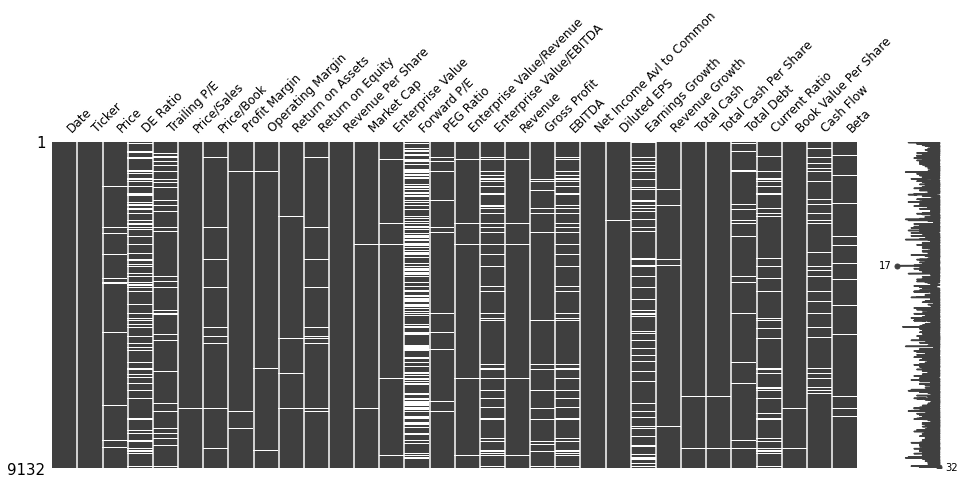

In [ ]:
_ = msno.matrix(key_stats_df, figsize=(16,6), fontsize=12)

In [ ]:
print("Overview of the missing values in the key_stats dataframe\n")
key_stats_summary = key_stats_df.isna().sum()           \
                        .sort_values(ascending=False)   \
                        .apply(lambda x: f"{round(100*x/len(key_stats_df.index), 3)}%")
key_stats_summary

Overview of the missing values in the key_stats dataframe



Forward P/E                  41.251%
DE Ratio                     16.886%
Earnings Growth              15.966%
Enterprise Value/EBITDA      10.633%
EBITDA                        10.37%
Current Ratio                 10.37%
Cash Flow                     9.801%
Trailing P/E                  8.432%
Beta                          4.413%
PEG Ratio                     4.325%
Gross Profit                   3.92%
Total Debt                    3.844%
Price                         3.657%
Return on Equity              3.011%
Return on Assets              2.508%
Price/Book                    2.354%
Revenue Growth                2.146%
Operating Margin              1.391%
Enterprise Value/Revenue      0.942%
Revenue                       0.909%
Total Cash                    0.854%
Enterprise Value              0.723%
Total Cash Per Share          0.712%
Profit Margin                 0.712%
Price/Sales                   0.548%
Book Value Per Share          0.449%
Diluted EPS                   0.296%
M

In [ ]:
summary = prices_df_nan_summary(prices_dfs, dfs_names)
px.bar(summary, x='Stock name', y='Missing data (%)', hover_data=['Count'], title="Stock price dataset before preprocessing (only columns with missing values are displayed)")

For most of the above stocks with missing values, we noticed that they indeed exist up to a given time and after that no more data is available. It may due to a business failure, hence no more stocks will be exchanged from that moment on.

In [ ]:
# Clear our input data from training NaN values
prices_dfs_new = [remove_trailing_nan(df,name) for df,name in zip(prices_dfs, dfs_names)]

# Remove INTH stock from our dataset since it contains many inactivity periods
if 'INTH' in dfs_names:
    inth_idx = dfs_names.index('INTH')
    del dfs_names[inth_idx]
    del prices_dfs_new[inth_idx]

summary = prices_df_nan_summary(prices_dfs_new, dfs_names)
px.bar(summary, x='Stock name', y='Missing data (%)', hover_data=['Count'], title="Stock price dataset after preprocessing (only columns with missing values are displayed)")

At this point we use the fast forward imputation technique to fill-in missing values. Please note that in this case missing values are mostly due to holidays or periods when stocks are not exchanged.

## Building the new dataset
We impute missing values, merge the two datasets, fill missing days and compute additional features (e.g. RSI).

In [ ]:
# Impute missing values in the prices dataset (i.e. fast-forward last valid values)
prices_dfs_new = [df.fillna(method='ffill') for df in prices_dfs_new]
assert pd.concat(prices_dfs_new).isnull().sum().sum() == 0

# In this case this dataframe contains financial reports that may contain NaN values either because that
# metric was not available at that time OR because it was monitoring an initial stage of a company growth.
# What we do is to apply the classic fast-forward, and fill initial missing values with zeroes.
# Please note: we also discard the 'Forward P/E' column since the imputation here would introduce too much noise.
key_stats_df_new = key_stats_df.drop('Forward P/E', axis=1).fillna(method='ffill').fillna(0.)
assert key_stats_df_new.isnull().sum().sum() == 0

# Before merging the two datasets we need to sort them
prices_dfs_new = [df.sort_values(by=['Date']).reset_index(drop=True) for df in prices_dfs_new]
key_stats_df_new = key_stats_df_new.sort_values(by=['Date']).reset_index(drop=True)

# Merge the stock price dataset with fundamental data of the relative company
aggregate_dfs, ticker_names = merge_prices_fundamentals(prices_dfs_new, key_stats_df_new, dfs_names)
assert pd.concat(aggregate_dfs).isnull().sum().sum() == 0

# Fill gaps from the original dataset
dfs, ticker_names = fill_missing_days(aggregate_dfs, ticker_names)
assert pd.concat(dfs).isnull().sum().sum() == 0

# Add SMA indicator to each dataframe
add_sma(dfs)

# Add RSI indicator to each dataframe
add_rsi(dfs)

## Creating sliding window dataset

In [ ]:
class SlidingWindowDataset(Dataset):
    '''
    A Dataset structure that shapes the input data according to the sliding window approach.
    Prices data consist of (x,y) window pairs of the following format:
        x: (window_size, feature_size)
        y: (1,target_cols)
    '''
    def __init__(
        self,
        prices: np.ndarray,
        indexes: np.ndarray,
        target_idx: int,
        columns: Optional[List[str]] = None
        ) -> None:
        self.prices = prices
        self.indexes = indexes
        self.target_idx = target_idx
        self.columns = columns

    @property
    def shape(self):
        return (self.indexes.shape[0], self.indexes.shape[1]-1, self.prices.shape[1])

    def __getitem__(self, index: int) -> Tuple[np.ndarray, np.ndarray]:
        x_idxs, y_idx = self.indexes[index, :-1], self.indexes[index, -1]
        return self.prices[x_idxs], self.prices[y_idx, self.target_idx]

    def __len__(self) -> int:
        return self.indexes.shape[0]

    def store(
        self,
        idx_path: str = 'data/preprocessed/indexes.npy',
        prices_path: str ='data/preprocessed/prices.npy'
        ) -> None:
        ''' Stores the collection of price values without the window size constraint, hence reducing output size. '''
        dir_path, _ = os.path.split(idx_path)
        os.makedirs(dir_path, exist_ok=True)
        dir_path, _ = os.path.split(prices_path)
        os.makedirs(dir_path, exist_ok=True)
        with open(idx_path, 'wb') as f1, open(prices_path, 'wb') as f2:
            np.save(f1, self.prices, allow_pickle=allow_pickle)
            np.save(f2, self.indexes, allow_pickle=allow_pickle)
    
    @classmethod
    def from_files(
        self,
        idx_path: str = 'data/preprocessed/indexes.npy',
        prices_path: str = 'data/preprocessed/prices.npy',
        target_col_idx: int = 30    # Index for adjusted close
        ) -> None:
        with open(idx_path, 'wb') as f1, open(prices_path, 'wb') as f2:
            prices = np.load(f1)
            indexes = np.load(f2)
        return cls(prices, indexes, target_col_idx)

    @classmethod
    def from_dfs(
        cls,
        dfs: List[pd.DataFrame],
        window_size: int = 20,
        target_col: str = 'Adjusted Close',
        val_date: str = '2012-01-01',
        test_date: str = '2013-01-01'
        ):

        # Split the dataset into train/val/test using these dates as boundaries
        val_begin = pd.Timestamp(val_date)
        test_begin = pd.Timestamp(test_date)

        # Init general variables
        columns = dfs[0].columns.values
        date_col_idx = np.where(columns == 'Date')[0][0]
        target_col_idx = np.where(columns == target_col)[0]

        # ... same
        train_stack, val_stack, test_stack = [], [], []
        train_split, val_split, test_split = [], [], []
        train_offset, val_offset, test_offset = 0, 0, 0
        
        for df in tqdm(dfs, desc='Loading datasets from dataframes ...'):
            df_np = df.to_numpy()

            # Compute the indexes on which to split each dataframe
            train_idxs = np.where(df_np[:, date_col_idx] < val_begin)[0]
            val_idxs = np.where((df_np[:, date_col_idx] >= val_begin) & (df_np[:, date_col_idx] < test_begin))[0]
            test_idxs = np.where(df_np[:, date_col_idx] >= test_begin)[0]

            # If we have enough data to form a window ... (of size n+1 for the target row)
            if len(train_idxs) > window_size + 1:
                # Unroll a window over training indexes and select training rows
                train_windows = train_offset + torch.from_numpy(train_idxs).unfold(0, window_size+1, 1)
                train_stack.append(train_windows)
                train_split.append(df.iloc[train_idxs])
                train_offset += len(train_idxs)

            # ... same
            if len(val_idxs) > window_size + 1:
                # ... same, but we are interested in relative indexes (hence substract the first element)
                val_windows = val_offset + torch.from_numpy(val_idxs - val_idxs[0]).unfold(0, window_size+1, 1)
                val_stack.append(val_windows)
                val_split.append(df.iloc[val_idxs])
                val_offset += len(val_idxs)
            
            # ... same
            if len(test_idxs) > window_size + 1:
                # ... same, but we are interested in relative indexes (hence substract the first element)
                test_windows = test_offset + torch.from_numpy(test_idxs - test_idxs[0]).unfold(0, window_size+1, 1)
                test_stack.append(test_windows)
                test_split.append(df.iloc[test_idxs])
                test_offset += len(test_idxs)

        # The list of features used for training (without dropped cols)
        drop_cols = ['Date', 'Overbought', 'Oversold']
        columns = dfs[0].columns.drop(drop_cols + ['Ticker']).tolist()
        _columns = dfs[0].columns.drop(drop_cols).tolist()

        scalable_features = ['DE Ratio', 'Trailing P/E', 'Price/Sales', 'Price/Book',
            'Profit Margin', 'Operating Margin', 'Return on Assets',
            'Return on Equity', 'Revenue Per Share', 'Market Cap',
            'Enterprise Value', 'PEG Ratio', 'Enterprise Value/Revenue',
            'Enterprise Value/EBITDA', 'Revenue', 'Gross Profit', 'EBITDA',
            'Net Income Avl to Common ', 'Diluted EPS', 'Earnings Growth',
            'Revenue Growth', 'Total Cash', 'Total Cash Per Share', 'Total Debt',
            'Current Ratio', 'Book Value Per Share', 'Cash Flow', 'Beta', 'Volume',
            'Adjusted Close', 'SMA', 'RSI']

        # Compute dataset statistics from the train split
        train_data = pd.concat(train_split).drop(drop_cols + ['Ticker'], axis=1)
        mean_vec = train_data[scalable_features].mean()
        std_vec = train_data[scalable_features].std()
        target_idx = scalable_features.index(target_col)

        # Create train/val/test splits with sliding windows, dropping unused columns
        # ... scaling train/val/test to have zero mean and unit variance,
        # ... keeping _test unaltered and using it as a parallel test split (i.e. to evaluate the trading strategy)
        train_data[scalable_features] = (train_data[scalable_features] - mean_vec) / std_vec
        train_idxs = torch.cat(train_stack)
        train_ds = cls(train_data.to_numpy(), train_idxs, target_col_idx-1, columns)

        val_data = pd.concat(val_split).drop(drop_cols + ['Ticker'], axis=1)
        val_data[scalable_features] = (val_data[scalable_features] - mean_vec) / std_vec
        val_idxs = torch.cat(val_stack)
        val_ds = cls(val_data.to_numpy(), val_idxs, target_col_idx-1, columns)

        test_idxs = torch.cat(test_stack)
        test_data = pd.concat(test_split).drop(drop_cols, axis=1)
        _test_ds = cls(test_data.copy().to_numpy(), test_idxs, target_col_idx-1, _columns)
        test_data[scalable_features] = (test_data[scalable_features] - mean_vec) / std_vec
        test_ds = cls(test_data.to_numpy(), test_idxs, target_col_idx-1, _columns)

        price_idx = columns.index(target_col)
        return train_ds, val_ds, test_ds, _test_ds, (mean_vec[target_idx], std_vec[target_idx], price_idx)

class SlidingWindowDataModule(pl.LightningDataModule):
    def __init__(
        self,
        ds_splits: List[SlidingWindowDataset],
        batch_size: int = 128
        ) -> None:
        super().__init__()
        self.train_ds, self.val_ds, self.test_ds, self._test_ds = ds_splits
        self.batch_size = batch_size        

    def train_dataloader(self) -> DataLoader:
        return DataLoader(self.train_ds, batch_size=self.batch_size, drop_last=True, pin_memory=True, shuffle=True)
    
    def val_dataloader(self) -> DataLoader:
        return DataLoader(self.val_ds, batch_size=self.batch_size, drop_last=True, pin_memory=True)

    def compute_test_mask(self, ticker: str) -> Tuple[int, np.ndarray, List[str]]:
        ''' Compute the mask on the test split to test on a given stock. '''
        ticker_idx = self._test_ds.columns.index('Ticker')
        mask = self._test_ds.prices[:, ticker_idx] == ticker
        mask_idxs = np.where(mask)[0]
        start, end = mask_idxs[0], mask_idxs[-1]
        new_idxs = np.where((self._test_ds.indexes[:, 0] >= start) & (self._test_ds.indexes[:, -1] <= end))[0]
        ticker_idxs = self._test_ds.indexes[new_idxs]
        ticker_prices = self._test_ds.prices[:, ticker_idx+1:].astype(float)
        new_columns = self._test_ds.columns[ticker_idx+1:]
        return ticker_idx, ticker_idxs, new_columns

    def test_dataloader(self, ticker: str) -> DataLoader:
        ticker_idx, ticker_idxs, new_columns = self.compute_test_mask(ticker)
        ticker_prices = self.test_ds.prices[:, ticker_idx+1:].astype(float)
        ticker_ds = SlidingWindowDataset(ticker_prices, ticker_idxs, self.test_ds.target_idx, new_columns)
        return DataLoader(ticker_ds, batch_size=self.batch_size, pin_memory=True)
    
    def _test_dataloader(self, ticker: str) -> DataLoader:
        ticker_idx, ticker_idxs, new_columns = self.compute_test_mask(ticker)
        ticker_prices = self._test_ds.prices[:, ticker_idx+1:].astype(float)
        ticker_ds = SlidingWindowDataset(ticker_prices, ticker_idxs, self._test_ds.target_idx, new_columns)
        return DataLoader(ticker_ds, batch_size=self.batch_size, pin_memory=True)

The dataset can be created either locally on your pc from the dataframes. You can do it calling the ````from_dfs```` method, or loading a preprocessed dataset calling the ```from_files``` method and specifying the required paths.

In [ ]:
# Preprocess the dataset using DataFrames
*ds_splits, (price_mean, price_std, price_idx) = SlidingWindowDataset.from_dfs(dfs, window_size=20)

# Persist out the preprocessed dataset to reuse it later
#ds.store()

# Load preprocessed dataset from files
#ds = SlidingWindowDataset.from_files()

ds = SlidingWindowDataModule(ds_splits, batch_size=1024)

## Hyperparameters
Here we define the list of hyperparameters that are used to define the shape of the dataset and models' behaviours.

In [ ]:
@dataclass
class HParams:
  input_dim: int = ds_splits[0].shape[2]  # Denoted by data transformations
  window_size: int = ds_splits[0].shape[1]
  batch_size: int = ds.batch_size
  features: int = field(default_factory=list)
  hidden_dim: int = 128
  num_layers: int = 1
  dropout: int = 0.5
  lr: int = 0.1
  num_heads: int = -1
  epochs: int = 5
  test_stock: str = 't'

## Models definition

In [ ]:
class SimpleLSTM(nn.Module):
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        self.lstm = nn.LSTM(hparams.input_dim, hparams.hidden_dim, num_layers=hparams.num_layers, batch_first=True)
        self.fc1 = nn.Linear(hparams.hidden_dim, hparams.hidden_dim//2)
        self.fc2 = nn.Linear(hparams.hidden_dim//2, 1)
        self.dropout = nn.Dropout(hparams.dropout)

    def forward(self, x: np.ndarray):
        x, (h,c) = self.lstm(x)
        h = self.dropout(h)
        h = h.view(self.hparams.num_layers, -1, self.hparams.hidden_dim)[-1]
        x = torch.relu(self.fc1(h))
        x = self.fc2(x)
        return x

class SimpleGRU(nn.Module):
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        self.gru = nn.GRU(hparams.input_dim, hparams.hidden_dim, num_layers=hparams.num_layers, batch_first=True)
        self.fc1 = nn.Linear(hparams.hidden_dim, hparams.hidden_dim//2)
        self.fc2 = nn.Linear(hparams.hidden_dim//2, 1)
        self.dropout = nn.Dropout(hparams.dropout)

    def forward(self, x: np.ndarray):
        x, h = self.gru(x)
        h = self.dropout(h)
        h = h.view(self.hparams.num_layers, -1, self.hparams.hidden_dim)[-1]
        x = torch.relu(self.fc1(h))
        x = self.fc2(x)
        return x

class ConvolutionalGRU(nn.Module):
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        self.cnn = nn.Conv1d(hparams.input_dim, hparams.input_dim*2, kernel_size=5)
        self.gru = nn.GRU(hparams.input_dim*2, hparams.hidden_dim, num_layers=hparams.num_layers, batch_first=True)
        self.fc1 = nn.Linear(hparams.hidden_dim, hparams.hidden_dim//2)
        self.fc2 = nn.Linear(hparams.hidden_dim//2, 1)
        self.dropout = nn.Dropout(hparams.dropout)

    def forward(self, x: np.ndarray):
        x = torch.einsum('bwn->bnw', x)
        x = torch.relu(self.cnn(x))
        x = torch.einsum('bnw->bwn', x)
        x, h = self.gru(x)
        h = self.dropout(h)
        h = h.view(self.hparams.num_layers, -1, self.hparams.hidden_dim)[-1]
        x = torch.relu(self.fc1(h))
        x = self.fc2(x)
        return x

class AttentionGRU(nn.Module):
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        self.att = nn.MultiheadAttention(hparams.input_dim, num_heads=hparams.num_heads)
        self.gru = nn.GRU(hparams.input_dim, hparams.hidden_dim, num_layers=hparams.num_layers, batch_first=True)
        self.fc1 = nn.Linear(hparams.hidden_dim, hparams.hidden_dim//2)
        self.fc2 = nn.Linear(hparams.hidden_dim//2, 1)
        self.dropout = nn.Dropout(hparams.dropout)

    def forward(self, x: np.ndarray):
        # Workaround since currently nn.MultiheadAttention does not support batch_first
        x = torch.einsum('bwn->wbn', x)
        x, _ = self.att(x, x, x)
        x = torch.einsum('wbn->bwn', x)
        x, h = self.gru(x)
        h = self.dropout(h)
        h = h.view(self.hparams.num_layers, -1, self.hparams.hidden_dim)[-1]
        x = torch.relu(self.fc1(h))
        x = self.fc2(x)
        return x

class StockPriceRegressor(pl.LightningModule):
    def __init__(self, model: nn.Module, hparams: Dict[str, any]):
        super().__init__()
        self.save_hyperparameters(asdict(hparams))
        self.loss_fn = nn.MSELoss()
        self.model = model

    def training_step(self, batch: Tuple[np.ndarray, np.ndarray], batch_idx: int):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss_fn(y_hat, y)
        return loss

    @torch.no_grad()
    def evaluation(self, batch: Tuple[np.ndarray, np.ndarray]) -> float:
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss_fn(y_hat, y)
        r2 = r2_score(y_hat, y)
        # p := no. of explanatory variables in the model (i.e window_size * feature_size)
        r2_adj = adjusted_r2_score(y_hat, y, x.shape[1] * x.shape[2])
        return loss, r2, r2_adj

    def validation_step(self, batch: Tuple[np.ndarray, np.ndarray], batch_idx: int) -> None:
        loss, r2, r2_adj = self.evaluation(batch)
        metrics = {'val_loss': loss, 'val_r2': r2, 'val_r2_adj': r2_adj}
        self.log_dict(metrics)

    def test_step(self, batch: Tuple[np.ndarray, np.ndarray], batch_idx: int) -> None:
        loss, r2, r2_adj = self.evaluation(batch)
        metrics = {'test_loss': loss, 'test_r2': r2, 'test_r2_adj': r2_adj}
        self.log_dict(metrics)

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.hparams.lr)

## Experiments
In this section we show a collection of experiments that we did to test RNN architectures on our task.

### Naive GRU

In [ ]:
hparams = HParams()
hparams.features = ds_splits[0].columns
hparams.epochs = 10

run = wandb.init(reinit=True, project='spf')
gru = SimpleGRU(hparams).double()
model = StockPriceRegressor(gru, hparams)
trainer = pl.Trainer(
    logger = WandbLogger(),
    log_every_n_steps = 1,
    gpus = 1 if torch.cuda.is_available() else 0,
    max_epochs = hparams.epochs,
    deterministic=True
)
trainer.fit(model, ds)
trainer.test(model, ds.test_dataloader(hparams.test_stock))
run.finish()

# A practical evaluation strategy based on profit estimation
evaluate_trading_strategy(model.model, ds, len(dfs), price_idx=price_idx, target_ticker=hparams.test_stock)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params
--------------------------------------
0 | loss_fn | MSELoss   | 0     
1 | model   | SimpleGRU | 70.5 K
--------------------------------------
70.5 K    Trainable params
0         Non-trainable params
70.5 K    Total params
0.282     Total estimated model params size (MB)


Global seed set to 42


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.0013822381871297909,
 'test_r2': -5.0861162188261675,
 'test_r2_adj': 4.6516697312957005}
--------------------------------------------------------------------------------


val_loss,0.00827
val_r2,0.98995
val_r2_adj,0.97316
epoch,9
trainer/global_step,4830
_runtime,629
_timestamp,1624181631
_step,10
test_loss,0.00138
test_r2,-5.08612
test_r2_adj,4.65167


val_loss,█▃▂▂▂▁▂▄▁▁
val_r2,▁▆▅▇▇▇▇▅██
val_r2_adj,▁▆▅▇▇▇▇▅██
epoch,▁▂▃▃▄▅▆▆▇██
trainer/global_step,▁▂▃▃▄▅▆▆▇██
_runtime,▁▂▃▃▄▅▆▆▇██
_timestamp,▁▂▃▃▄▅▆▆▇██
_step,▁▂▂▃▄▅▅▆▇▇█
test_loss,▁
test_r2,▁
test_r2_adj,▁


Evaluating trading strategy ...
1-year profit: 83.82514246947896%
Operation accuracy: 61.44578313253012%


### Naive LSTM

In [ ]:
hparams = HParams()
hparams.features = ds_splits[0].columns
hparams.epochs = 10

run = wandb.init(reinit=True, project='spf')
lstm = SimpleLSTM(hparams).double()
model = StockPriceRegressor(lstm, hparams)
trainer = pl.Trainer(
    logger = WandbLogger(),
    log_every_n_steps = 1,
    gpus = 1 if torch.cuda.is_available() else 0,
    max_epochs = hparams.epochs,
    deterministic=True
)
trainer.fit(model, ds)
trainer.test(model, ds.test_dataloader(hparams.test_stock))
run.finish()

# A practical evaluation strategy based on profit estimation
evaluate_trading_strategy(model.model, ds, len(dfs), price_idx=price_idx, target_ticker=hparams.test_stock)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | model   | SimpleLSTM | 91.3 K
---------------------------------------
91.3 K    Trainable params
0         Non-trainable params
91.3 K    Total params
0.365     Total estimated model params size (MB)


Global seed set to 42


wandb: Network error resolved after 0:00:46.686687, resuming normal operation.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.003250673553786538,
 'test_r2': -13.313001349565413,
 'test_r2_adj': 9.587800809739248}
--------------------------------------------------------------------------------


val_loss,0.01725
val_r2,0.98758
val_r2_adj,0.96682
epoch,9
trainer/global_step,4830
_runtime,672
_timestamp,1624182306
_step,10
test_loss,0.00325
test_r2,-13.313
test_r2_adj,9.5878


val_loss,█▄▄▃▂▁▂▄▂▂
val_r2,▁▆▆▅▄▅▆▅▇█
val_r2_adj,▁▆▆▅▄▅▆▅▇█
epoch,▁▂▃▃▄▅▆▆▇██
trainer/global_step,▁▂▃▃▄▅▆▆▇██
_runtime,▁▂▃▃▄▅▆▆▇██
_timestamp,▁▂▃▃▄▅▆▆▇██
_step,▁▂▂▃▄▅▅▆▇▇█
test_loss,▁
test_r2,▁
test_r2_adj,▁


Evaluating trading strategy ...
1-year profit: 49.806095554526536%
Operation accuracy: 59.210526315789465%


### Attention-based GRU

In [ ]:
hparams = HParams()
hparams.features = ds_splits[0].columns
hparams.epochs = 10
hparams.num_heads = 4

run = wandb.init(reinit=True, project='spf')
gru = AttentionGRU(hparams).double()
model = StockPriceRegressor(gru, hparams)
trainer = pl.Trainer(
    logger = WandbLogger(),
    log_every_n_steps = 1,
    gpus = 1 if torch.cuda.is_available() else 0,
    max_epochs = hparams.epochs,
    deterministic=True
)
trainer.fit(model, ds)
trainer.test(model, ds.test_dataloader(hparams.test_stock))
run.finish()

# A practical evaluation strategy based on profit estimation
evaluate_trading_strategy(model.model, ds, len(dfs), price_idx=price_idx, target_ticker=hparams.test_stock)

wandb: Currently logged in as: leonardoemili (use `wandb login --relogin` to force relogin)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params
-----------------------------------------
0 | loss_fn | MSELoss      | 0     
1 | model   | AttentionGRU | 74.8 K
-----------------------------------------
74.8 K    Trainable params
0         Non-trainable params
74.8 K    Total params
0.299     Total estimated model params size (MB)


Global seed set to 42


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.0001913891893395697,
 'test_r2': 0.1572965786987245,
 'test_r2_adj': 1.5056220527807653}
--------------------------------------------------------------------------------


val_loss,0.00926
val_r2,0.98376
val_r2_adj,0.95663
epoch,9
trainer/global_step,4830
_runtime,729
_timestamp,1624180276
_step,10
test_loss,0.00019
test_r2,0.1573
test_r2_adj,1.50562


val_loss,█▂▂▁▂▁▄▄▂▁
val_r2,▁▇▇█▆▇▅▆█▇
val_r2_adj,▁▇▇█▆▇▅▆█▇
epoch,▁▂▃▃▄▅▆▆▇██
trainer/global_step,▁▂▃▃▄▅▆▆▇██
_runtime,▁▂▃▃▄▅▆▆▇██
_timestamp,▁▂▃▃▄▅▆▆▇██
_step,▁▂▂▃▄▅▅▆▇▇█
test_loss,▁
test_r2,▁
test_r2_adj,▁


Evaluating trading strategy ...
1-year profit: 66.85811905534707%
Operation accuracy: 54.347826086956516%


### CNN-based GRU

In [ ]:
hparams = HParams()
hparams.features = ds_splits[0].columns
hparams.epochs = 10

run = wandb.init(reinit=True, project='spf')
lstm = ConvolutionalGRU(hparams).double()
model = StockPriceRegressor(gru, hparams)
trainer = pl.Trainer(
    logger = WandbLogger(),
    log_every_n_steps = 1,
    gpus = 1 if torch.cuda.is_available() else 0,
    max_epochs = hparams.epochs,
    deterministic=True
)
trainer.fit(model, ds)
trainer.test(model, ds.test_dataloader(hparams.test_stock))
run.finish()

# A practical evaluation strategy based on profit estimation
evaluate_trading_strategy(model.model, ds, len(dfs), price_idx=price_idx, target_ticker=hparams.test_stock)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params
-----------------------------------------
0 | loss_fn | MSELoss      | 0     
1 | model   | AttentionGRU | 74.8 K
-----------------------------------------
74.8 K    Trainable params
0         Non-trainable params
74.8 K    Total params
0.299     Total estimated model params size (MB)


Global seed set to 42


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.0002751299123561118,
 'test_r2': -0.21142118447167668,
 'test_r2_adj': 1.7268527106830058}
--------------------------------------------------------------------------------


val_loss,0.01152
val_r2,0.98697
val_r2_adj,0.96519
epoch,9
trainer/global_step,4830
_runtime,719
_timestamp,1624180998
_step,10
test_loss,0.00028
test_r2,-0.21142
test_r2_adj,1.72685


val_loss,▅▁▁▂▂▁▇█▃▃
val_r2,▄▇▇▆▆▇▁▃█▇
val_r2_adj,▄▇▇▆▆▇▁▃█▇
epoch,▁▂▃▃▄▅▆▆▇██
trainer/global_step,▁▂▃▃▄▅▆▆▇██
_runtime,▁▂▃▃▄▅▆▆▇██
_timestamp,▁▂▃▃▄▅▆▆▇██
_step,▁▂▂▃▄▅▅▆▇▇█
test_loss,▁
test_r2,▁
test_r2_adj,▁


Evaluating trading strategy ...
1-year profit: 85.21573768402295%
Operation accuracy: 63.52941176470588%
